In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from matplotlib import pyplot
from scipy import stats




In [2]:
def is_float(str):
    try:
        np.float64(str)
    except:
        return False
    else:
        return True

In [3]:
# Read the data

raw_data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
# Some samples have NaN 'TotalCharges'. Those are only new costumers having 'tenure' == 0.
# We fix them to 'TotalCharges' = 0
raw_data.loc[(raw_data['tenure'] == 0) & (~raw_data['TotalCharges'].apply(is_float)), 'TotalCharges'] = 0
raw_data['TotalCharges'] = raw_data['TotalCharges'].astype('float64')


print(f'Read {len(raw_data)} rows of data with {len(raw_data.columns)} columns')


Read 7043 rows of data with 21 columns


In [4]:
# List the categorical features
categorical_columns = [
    'gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'PhoneService',
    'MultipleLines',
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'Contract',
    'PaperlessBilling',
    'PaymentMethod',
]


In [5]:
def inflate_churn_data(samples, labels, tick_column_name, inflated_label):
        additional_samples = []
        for _, sample in samples.iterrows():
            additional_samples += get_additional_samples(sample, tick_column_name)
        inflated_samples = samples.append(additional_samples, ignore_index=True)

        additional_labels = [inflated_label for _ in additional_samples]
        inflated_labels = labels.append(pd.Series(additional_labels), ignore_index=True)

        inflated_samples = shuffle(inflated_samples, random_state=1234)
        inflated_labels = shuffle(inflated_labels, random_state=1234)
        
        inflated_samples.reset_index(drop=True, inplace=True)
        inflated_labels.reset_index(drop=True, inplace=True)

        return inflated_samples, inflated_labels

def get_additional_samples(sample, tick_column_name):
    num_ticks = sample[tick_column_name]
    return [clone_and_set(sample, tick_column_name, tick) for tick in range(0, num_ticks)]

def clone_and_set(sample, column_name, value):
    result = sample.copy()
    result[column_name] = value
    return result



In [6]:
# Convert each categorical feature to a continuous feature by replacing each category with its respective average label

class BucketStatsFeatureTransformer(TransformerMixin, BaseEstimator):
    def __init__(self, categorical_features, no_data_threshold, no_data_fallback):
        self.categorical_features = categorical_features
        self.no_data_threshold = no_data_threshold
        self.no_data_fallback = no_data_fallback
        print('BucketStatsFeatureTransformer:')
        print(f'categorical_features = {categorical_features}')
        print(f'no_data_threshold = {no_data_threshold}, no_data_fallback = {no_data_fallback}')

    def fit(self, x, y):
        if self.no_data_fallback is None:
            self.no_data_fallback = y.mean()
        self.stats_dict = {}
        for column_name in self.categorical_features:
            self.stats_dict[column_name] = self.get_one_column_stats(x, column_name, y)
        return self

    def get_one_column_stats(self, x, column_name, y):
        df = pd.concat([x[column_name], y], axis=1)
        df.columns = [column_name, 'label']
        stats = df.groupby([column_name])['label'].agg(['mean', 'count'])
        stats = stats[stats['count'] >= self.no_data_threshold]
        stats.drop('count', axis=1, inplace=True)

        print(f'Found {len(stats)} meaningful  buckets for categorical feature {column_name}')
        return stats
    
    def transform(self, x):
        for column_name in self.categorical_features:
            x = self.transform_one_column(x, column_name)
        return x

    def transform_one_column(self, x, column_name):
        stats_df = self.stats_dict[column_name]
        df = pd.merge(x, stats_df, how='left', left_on=column_name, right_index=True)
        df.loc[df['mean'].isna(), 'mean'] = self.no_data_fallback
        df.drop(column_name, axis=1, inplace=True)
        df.rename(columns={'mean': column_name}, inplace=True)
        return df



In [7]:
def convert_label(text_label):
    if text_label == 'Yes':
        return 1
    else:
        return 0

# x,y split - 'Churn' is our label
classification_label = raw_data['Churn'].apply(convert_label)

# Drop the label 'Churn' and 'customerID' which is meaningles
classification_features = raw_data.drop(['Churn', 'customerID'], axis=1)

# Do the train-test split before the churn inflation
x_train, x_test, y_train, y_test = train_test_split(classification_features,
                                                    classification_label,
                                                    test_size=0.2,
                                                    random_state=333)
print(f'Before inflation: train size = {len(x_train)}, test_size = {len(x_test)}')

# Churn inflation:
# We are actually adding no-churn samples for each month in the tenure period but the last.
# We do this on the raw data and not as part of the pipeline because:
# - We transform both x and y and not only x.
# - We are adding new samples not modifying existing ones.
# - This is done independently to the train and test data so there is nothing to learn/fit.
x_train, y_train = inflate_churn_data(x_train, y_train, 'tenure', 0)
x_test, y_test = inflate_churn_data(x_test, y_test, 'tenure', 0)
print(f'After inflation: train size = {len(x_train)}, test_size = {len(x_test)}')



Before inflation: train size = 5634, test_size = 1409
After inflation: train size = 186554, test_size = 48479


In [8]:
def print_prediction_scores(text, probabilities, label):
    diff = probabilities - label
    mae = abs(diff).mean()
    rmse = (diff * diff).mean()**0.5
    roc_auc = roc_auc_score(label, probabilities)
    print(f'{text}: {mae:.6f}, {rmse:.6f}, {roc_auc:.6f}')

def get_baseline_probabilities(y_train, y_test):
    global_ctr = y_train.mean()
    return [global_ctr for _ in range(y_test.shape[0])]

def get_better_baseline_probabilities(x_train, y_train, x_test, column_name):
    transformer = BucketStatsFeatureTransformer([column_name], no_data_threshold=0, no_data_fallback=None)
    transformer.fit(x_train, y_train)
    df = transformer.transform(x_test)
    return df[column_name]


BucketStatsFeatureTransformer:
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
no_data_threshold = 100, no_data_fallback = None
Starting XGBClassifier.fit()
Found 2 meaningful  buckets for categorical feature gender
Found 2 meaningful  buckets for categorical feature SeniorCitizen
Found 2 meaningful  buckets for categorical feature Partner
Found 2 meaningful  buckets for categorical feature Dependents
Found 2 meaningful  buckets for categorical feature PhoneService
Found 3 meaningful  buckets for categorical feature MultipleLines
Found 3 meaningful  buckets for categorical feature InternetService
Found 3 meaningful  buckets for categorical feature OnlineSecurity
Found 3 meaningful  buckets for categorical feature OnlineBackup
Found 3 meaningful  buckets for 

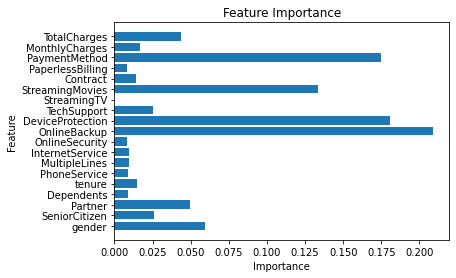

In [9]:
# XGBClassifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
                                  learning_rate=0.1, max_depth=3, reg_alpha=0, reg_lambda=0, n_estimators=500)
pipe = Pipeline([
    ('bucket_stats', BucketStatsFeatureTransformer(categorical_columns, no_data_threshold=100, no_data_fallback=None)),
    ('classifier', xgb_classifier)

])
print('Starting XGBClassifier.fit()')
model = pipe.fit(x_train, y_train)


feature_importances = xgb_classifier.feature_importances_
pyplot.barh(x_train.columns, feature_importances)
pyplot.title('Feature Importance')
pyplot.ylabel('Feature')
pyplot.xlabel('Importance')
pyplot.show()


In [10]:
baseline = get_baseline_probabilities(y_train, y_test)
better_baseline = get_better_baseline_probabilities(x_train, y_train, x_test, 'tenure')
model_probabilities = model.predict_proba(x_test)[:,1]
print('Scores: MAE, RMSE, AUC-ROC')
print_prediction_scores('baseline', baseline, y_test)
print_prediction_scores('better baseline', better_baseline, y_test)
print_prediction_scores('model prediction', model_probabilities, y_test)




BucketStatsFeatureTransformer:
categorical_features = ['tenure']
no_data_threshold = 0, no_data_fallback = None
Found 73 meaningful  buckets for categorical feature tenure
Scores: MAE, RMSE, AUC-ROC
baseline: 0.015380, 0.085737, 0.500000
better baseline: 0.015139, 0.085364, 0.677920
model prediction: 0.010060, 0.069416, 0.988213
